# Part II - Prosper Loan Analysis
## by Greatness Okeremeta

## Investigation Overview


> In this investigation I explore some variables that explain borrower behaviour towards loans, they can also be used to predict possibility of default. Focus was placed on the original loan amount, loan status, borrower's rate and Prosper rating, borrower's employment status and monthly income.


## Dataset Overview

> The Prosper loan data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan_df = pd.read_csv("prosperLoanData.csv")

In [3]:
# Create a subset of the dataset using relevant columns
relevant_cols = ['LoanKey', 'Term','LoanOriginalAmount','LoanOriginationDate', 'ListingNumber',
                 'LoanStatus','ListingCategory (numeric)','BorrowerAPR','BorrowerRate',
                 'BorrowerState' , 'CreditGrade', 'EmploymentStatus','StatedMonthlyIncome',
                 'MonthlyLoanPayment', 'ProsperRating (Alpha)', 'IncomeRange', 'TotalProsperLoans',
                 'Recommendations','Investors','DelinquenciesLast7Years']
subset_df = loan_df[relevant_cols]

In [4]:
## Preliminary Wrangling

# rename certain columns to display the dataframe more cleanly
subset_df.rename(columns={'ListingCategory (numeric)': 'ListingCategory', 'ProsperRating (Alpha)': 'ProsperRating'}, inplace=True);

# reduce the number of rows in the dataframe by removing the null values in the ProsperRating column
subset_df = subset_df[subset_df['ProsperRating'].notna()]

# convert the LoanOriginationDate columns to a Datetime datatype
subset_df['LoanOriginationDate'] = pd.to_datetime(subset_df['LoanOriginationDate'])

subset_df['TotalProsperLoans'] = subset_df['TotalProsperLoans'].fillna(0)

#set loan key as index
subset_df.set_index('LoanKey', inplace=True)

# replace the $0 income range category with "Not Employed"
subset_df.IncomeRange.replace({'$0': 'Not employed'}, inplace=True)

# Reorder the IncomeRange , EmploymentStatus, ProsperRating columns as ordered categorical variables
inc_dict = {'IncomeRange': ['Not displayed', 'Not employed', '$1-24,999', 
                           '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+'],
           'EmploymentStatus': ['Employed', 'Self-employed', 'Full-time',
                                'Part-time', 'Other', 'Retired'],
           'ProsperRating':['HR', 'E', 'D', 'C', 'B', 'A', 'AA']}
for i in inc_dict:
    order = pd.api.types.CategoricalDtype(ordered=True, categories = inc_dict[i])
    subset_df[i] = subset_df[i].astype(order);

## Loan Status Categories

> Most of the loans in the data set are current loans, followed by completed and charged-off loans, while we have a few defaulted loans. The loans that are past their due date are split into categories based on the length of delay in repayment.

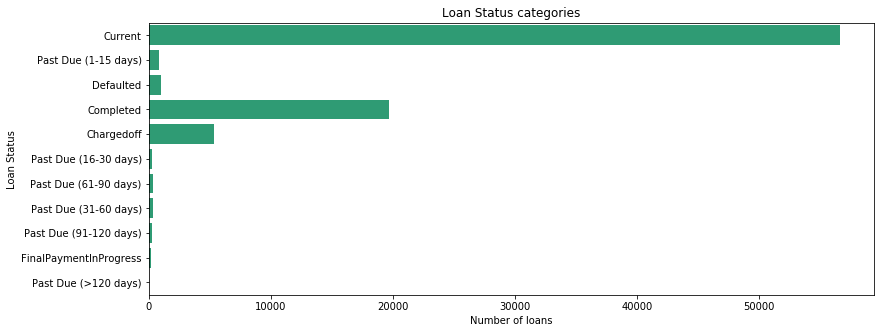

In [5]:
# Setting preferred color for all plots
p_color = '#1dad79'

# Set the figure size
fig, ax = plt.subplots(figsize=(13, 5))

# Plot the Loan Status variable
ls = sb.countplot(data=subset_df, y='LoanStatus', color=p_color);
ls.set(title ='Loan Status categories', xlabel = 'Number of loans', ylabel='Loan Status');

## Borrower/Interest Rate Distribution
> The interest rate is left-skewed with a sharp peak around 0.32% for aprroximately 4,000 loans. The largest number of loans are within the interest rates 0.1% and 0.3%, with a few loans having an interest rate less than 0.1%

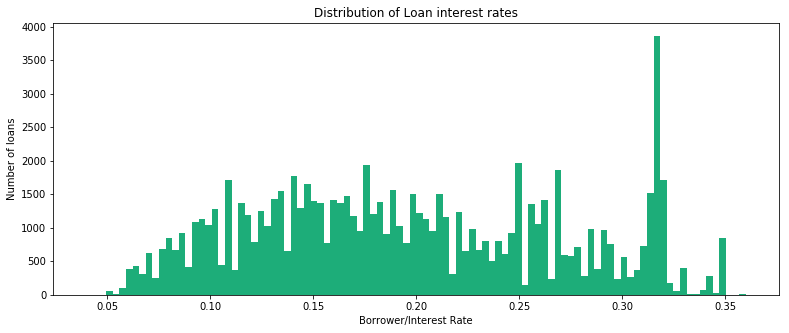

In [6]:
# Set the figure size
fig, ax = plt.subplots(figsize=(13, 5))

# Plot the interest rates for the loans
plt.hist(data = subset_df, x = 'BorrowerRate', color=p_color, bins = 100);
plt.xlabel('Borrower/Interest Rate');
plt.ylabel('Number of loans');
plt.title('Distribution of Loan interest rates');

## Loan Status and Prosper Rating

The prevalent Prosper rating amongst the current loans is C, with the ratings B and A following closely. Most of the completed and chargedoff loans have the rating - D.

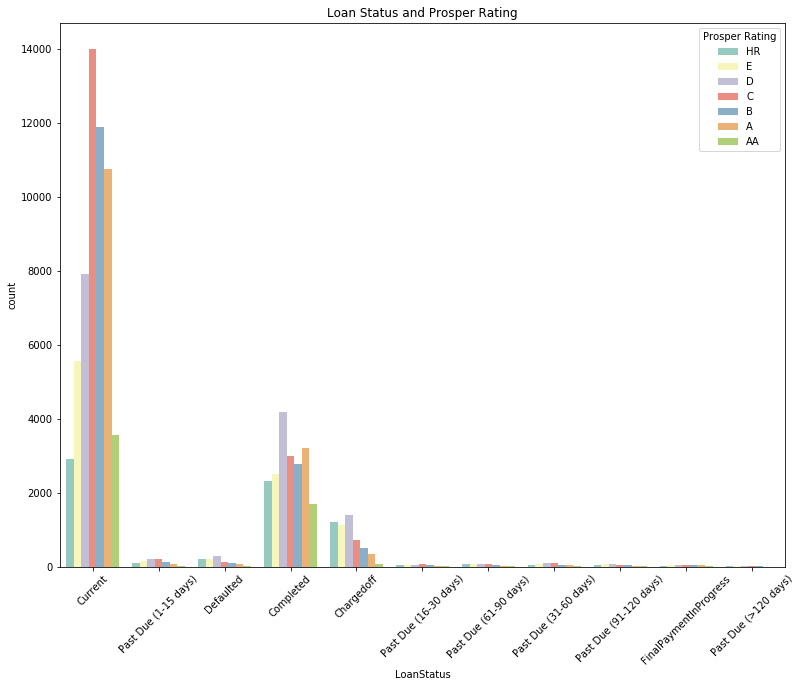

In [7]:
# Set the figure size
fig, ax = plt.subplots(figsize=(13, 10))

plot = sb.countplot(data = subset_df, x = 'LoanStatus', hue = 'ProsperRating', palette = 'Set3');
plot.set(title='Loan Status and Prosper Rating');
plt.xticks(rotation=45);
plt.legend(title = 'Prosper Rating', loc='upper right');

## Borrower Rate and Loan Original Amount

> There's a negative correlation between the Borrower/interest Rate and Loan Original Amount. As the loan amounts increase, the Borrower rate decreases and vice-versa. This might be an incentive to encourage individuals to take on higher valued loans

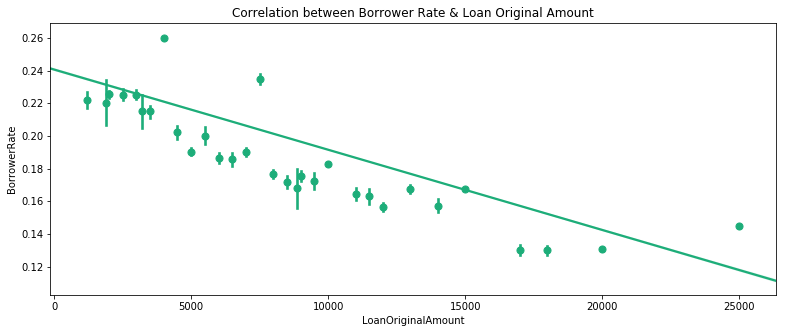

In [8]:
# Set the figure size
fig, ax = plt.subplots(figsize=(13, 5))

sb.regplot(data = subset_df, x = 'LoanOriginalAmount', y = 'BorrowerRate', x_bins = 100,
           color=p_color).set(title='Correlation between Borrower Rate & Loan Original Amount');

## Prosper Rating and Employment Status

> In all Prosper rating categories, the employed individuals constitute the majority with their highest population being in the C Prosper rating category. The lower Prosper ratings have more borrowers with employment status - Self-employed and Other. Following from the earlier plot showing Loan Status and Prosper Rating, we see that the employed individuals take on more loans than any other employment category.

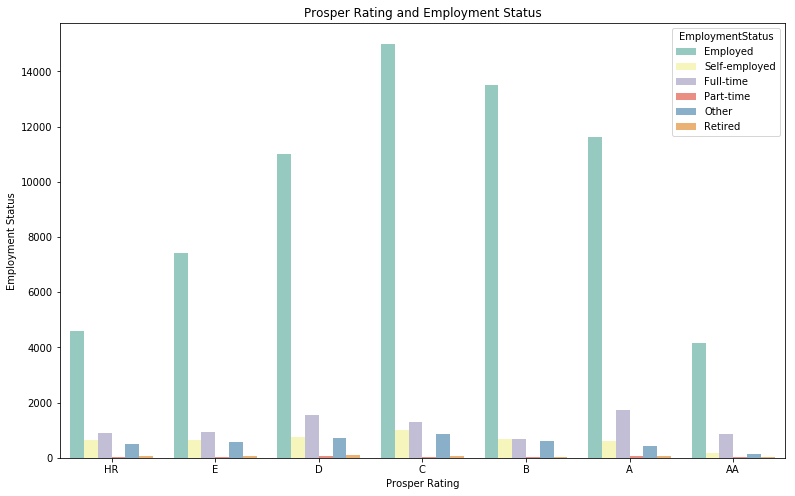

In [9]:
fig, ax = plt.subplots(figsize=(13, 8));
pr_es = sb.countplot(data = subset_df, x = 'ProsperRating', hue = 'EmploymentStatus', palette = 'Set3');
pr_es.set(title ='Prosper Rating and Employment Status',
          xlabel = 'Prosper Rating', ylabel='Employment Status');

## Loan Origination Year, Borrower/Interest Rate & Income Range

> The unemployed borrowers saw their interest rate increase every year with a marked increase in 2013. There was a sharp drop in interest rates in 2014 for borrowers in the \\$1 - \\$24,999 income range. All income groups saw a slight decrease in their interest rate in 2012. Only borrowers in the \\$50,000 - \\$74,999 income range saw an increase in interest rate in 2014.

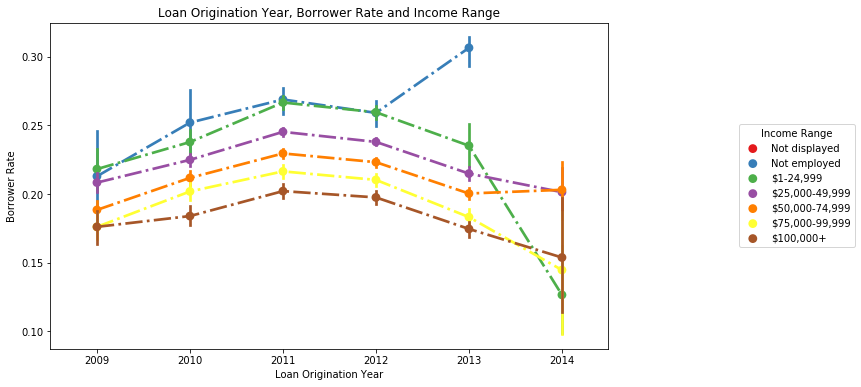

In [10]:
# Adjusting the Loan Status to only display Completed and Defaulted loans

setting = (subset_df['LoanStatus'] == 'Completed') | (subset_df['LoanStatus'] == 'Defaulted') |\
                  (subset_df['LoanStatus'] == 'Chargedoff')
subset_df = subset_df[setting]

#define a function to adjust the loan status to 2 values
def change(status):
    if status['LoanStatus'] == 'Chargedoff':
        return 'Defaulted'
    else:
        return status['LoanStatus']
    
subset_df['LoanStatus'] = subset_df.apply(change, axis=1)
subset_df['LoanStatus'].value_counts()

# set figure size
plt.figure(figsize = [10, 6])

b_rate = sb.pointplot(data = subset_df, x = subset_df['LoanOriginationDate'].dt.year, y = 'BorrowerRate', hue = 'IncomeRange', palette = 'Set1',\
             linestyles = '-.')
plt.legend(title = 'Income Range', loc = 'right', bbox_to_anchor=(1.45, 0.5), ncol=1);
b_rate.set(title ='Loan Origination Year, Borrower Rate and Income Range',
          xlabel = 'Loan Origination Year', ylabel='Borrower Rate');

### Loan Status, Loan Original Amount and Prosper Rating
> In most of the Prosper ratings categories, the completed loans are more than the defaulted loans. Most of the defaulted loans belong to individuals with high Prosper ratings.

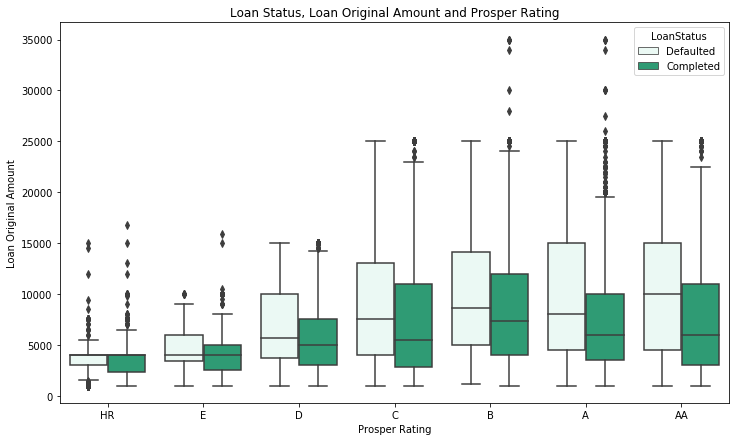

In [11]:
# set figure size
plt.figure(figsize = [12, 7])

pll = sb.boxplot(data=subset_df, x='ProsperRating', y='LoanOriginalAmount', color=p_color , hue='LoanStatus');
pll.set(title ='Loan Status, Loan Original Amount and Prosper Rating',
          xlabel = 'Prosper Rating', ylabel='Loan Original Amount');

### Listing Category, Loan Original Amount and Loan Status
> Loans for Business and Debt Consolidation are the most completed loans. Students use loans had the least amount of default while loans for Home Improvement had the highest number of defaults.

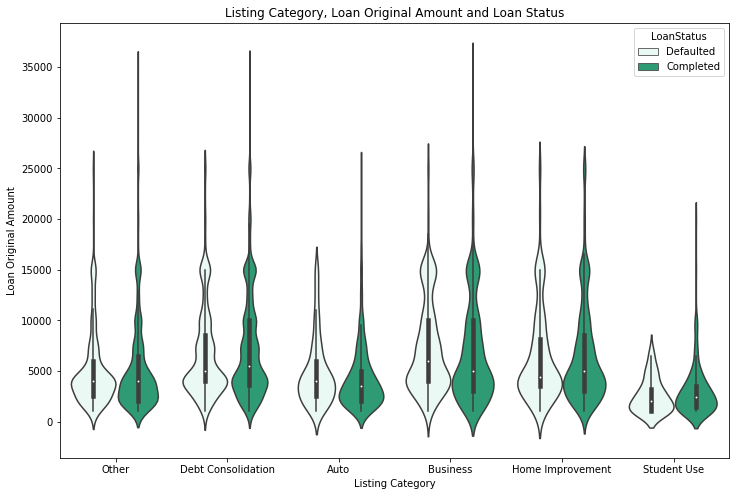

In [12]:
Listing_categories = {1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business',  
                      4: 'Personal Loan', 5: 'Student Use', 6: 'Auto', 7: 'Other'}
def minimize(categories):
    loan_category = categories['ListingCategory']
    if  loan_category in Listing_categories:
        return Listing_categories[loan_category]
    else:
        return Listing_categories[7]

# Check  
subset_df['ListingCategory'] = subset_df.apply(minimize, axis=1)

# set figure size
plt.figure(figsize = [12, 8])

lll =sb.violinplot(data=subset_df, x='ListingCategory', y='LoanOriginalAmount', color=p_color, hue='LoanStatus');
lll.set(title ='Listing Category, Loan Original Amount and Loan Status',
          xlabel = 'Listing Category', ylabel='Loan Original Amount');

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_notebook.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_notebook.ipynb to slides
[NbConvertApp] Writing 620203 bytes to Part_II_notebook.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_notebook.slides.html
Use Control-C to stop this server
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: x-www-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: firefox: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: iceweasel: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: seamonkey: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: mozilla: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: epiphany: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: konqueror: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: chromium-browser: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: google-chrome: not found
/usr/bin/xdg-open: 778: /usr/bin/xdg-open: www-browser: not found
